**Installing for module pmdarima**


In [ ]:
pip install pmdarima

**Import pandas/numpy and load the dataset first**

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
df=pd.read_csv('/content/merged_climate_population.csv')
provinces = df['Province'].unique()
df.head()

,Province,Year,Annual_Mean_Temp,Annual_Max_Temp,Annual_Min_Temp,Station_Count,GEO,Population
0,AB,1950,1.25,36.7,-46.1,96,Alberta,919744
1,AB,1951,0.88,38.9,-44.4,96,Alberta,939834
2,AB,1952,4.11,36.1,-36.7,104,Alberta,971500
3,AB,1953,4.39,38.9,-33.3,112,Alberta,1010250
4,AB,1954,3.08,40.0,-38.9,111,Alberta,1054250


<Axes: >

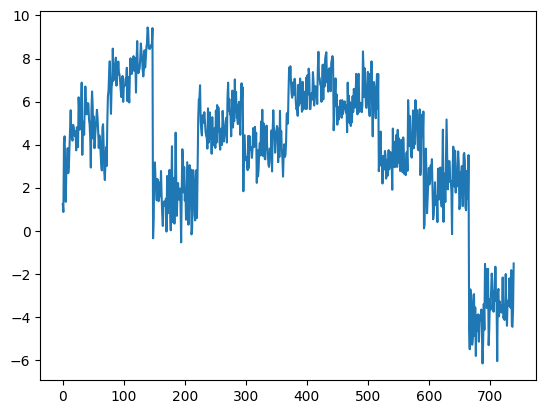

In [ ]:
df['Annual_Mean_Temp'].plot()

**Test the adfuller and output the result**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [ ]:
ad_test(df['Annual_Mean_Temp'])

1. ADF :  -1.531290950597676
2. P-Value :  0.5179793004107262
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 728
5. Critical Values :
	 1% :  -3.4393644334758475
	 5% :  -2.8655182850048306
	 10% :  -2.568888486973192


# Using pmdarim and auto_arima to train and test the model and predict the future temperature upto 2050 for each province in Canada

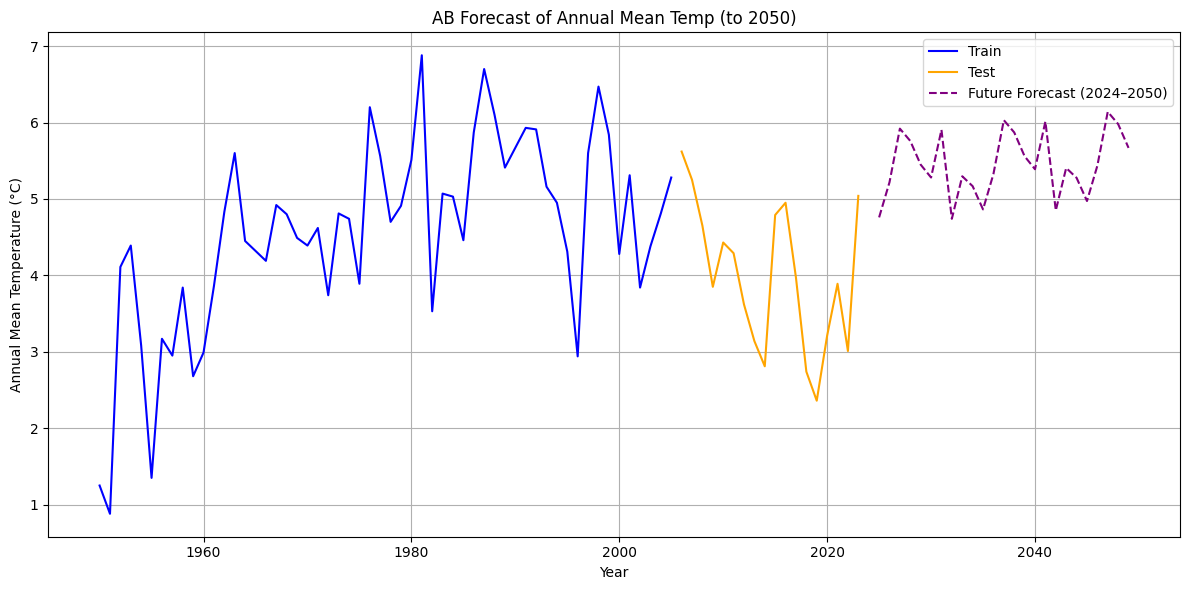

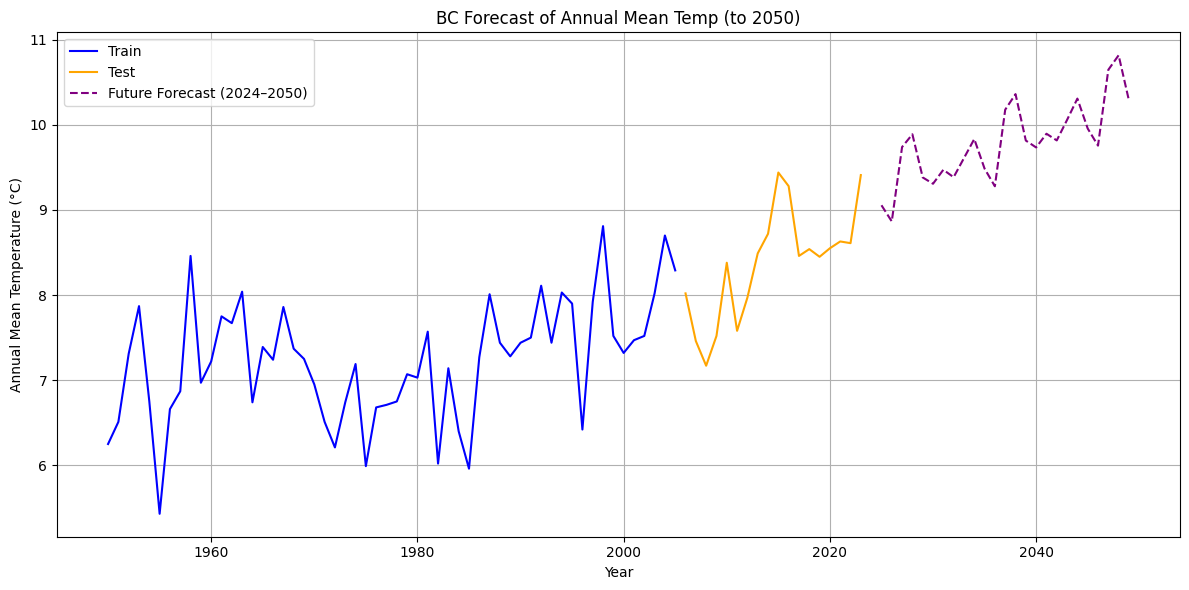

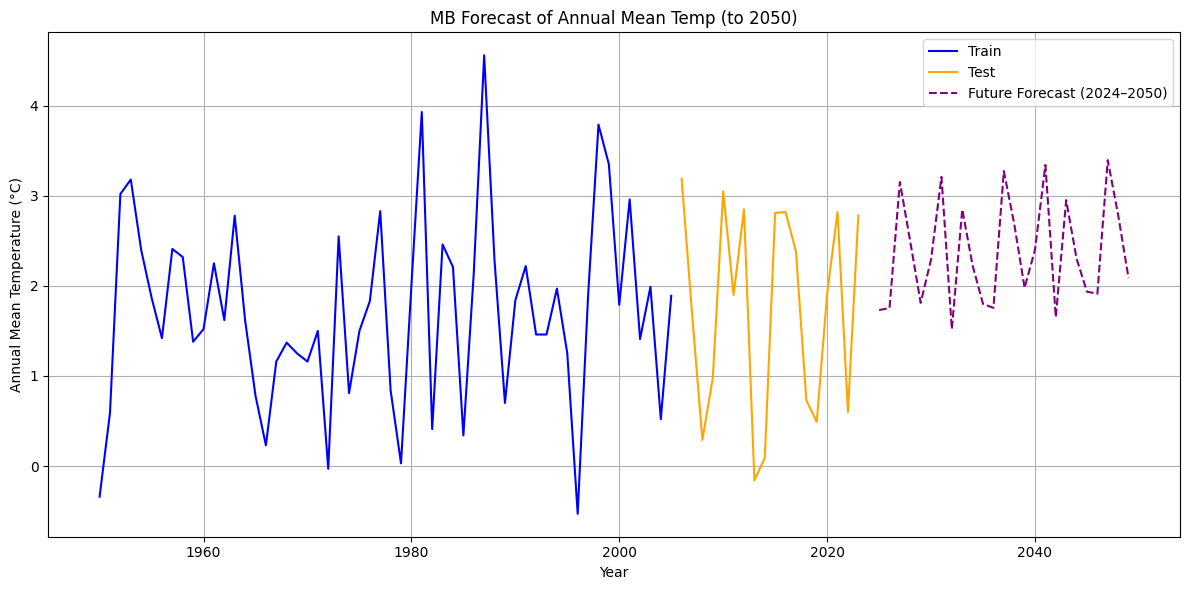

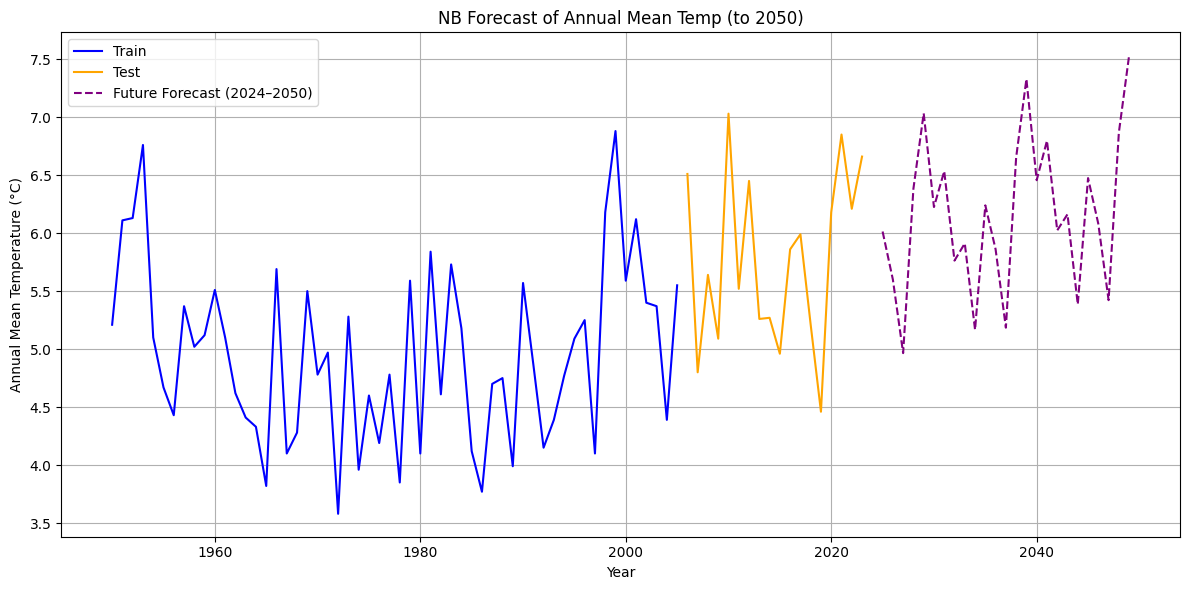

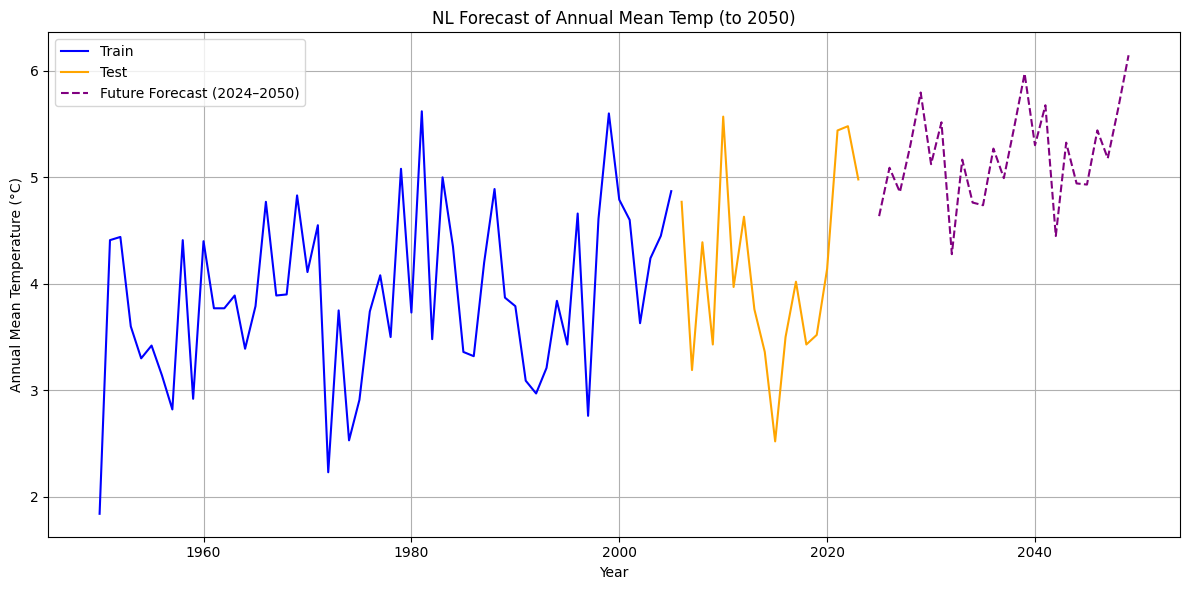

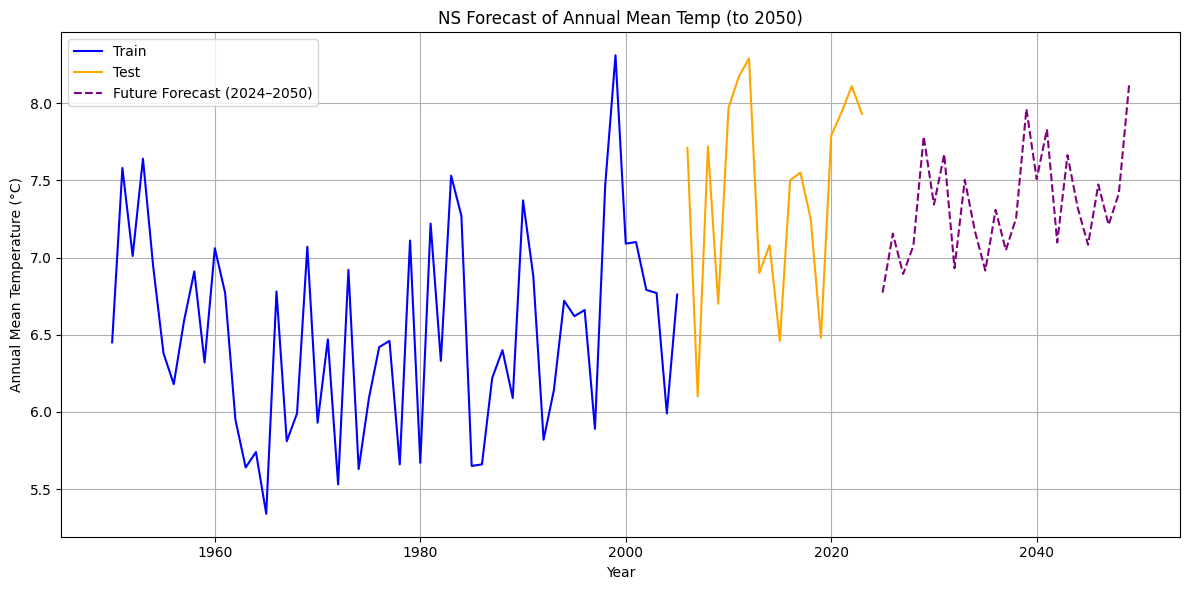

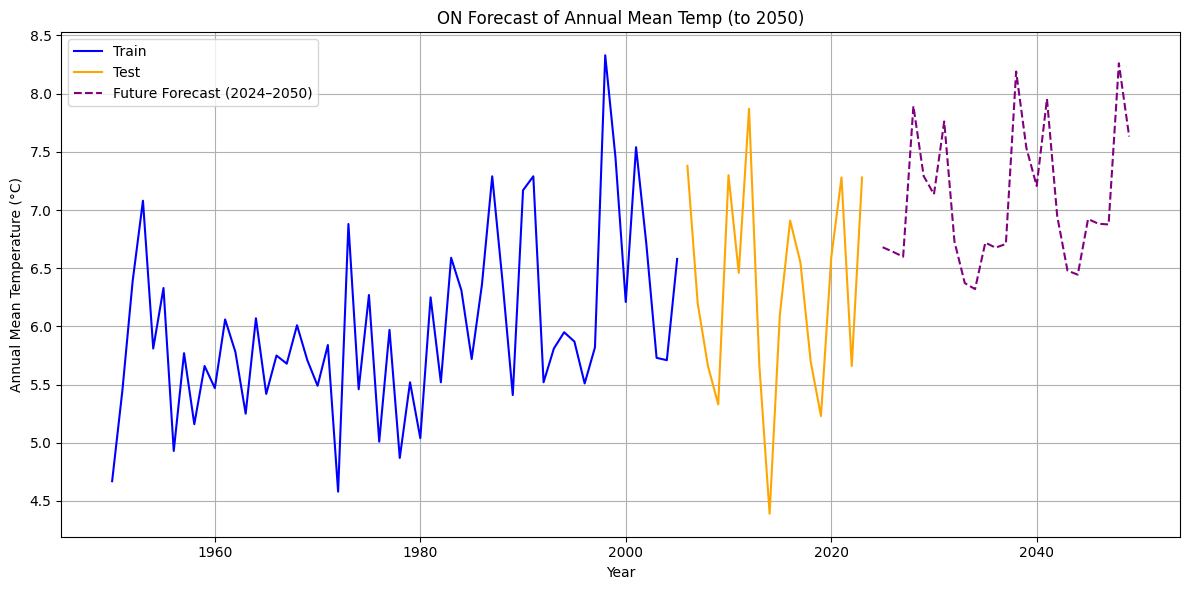

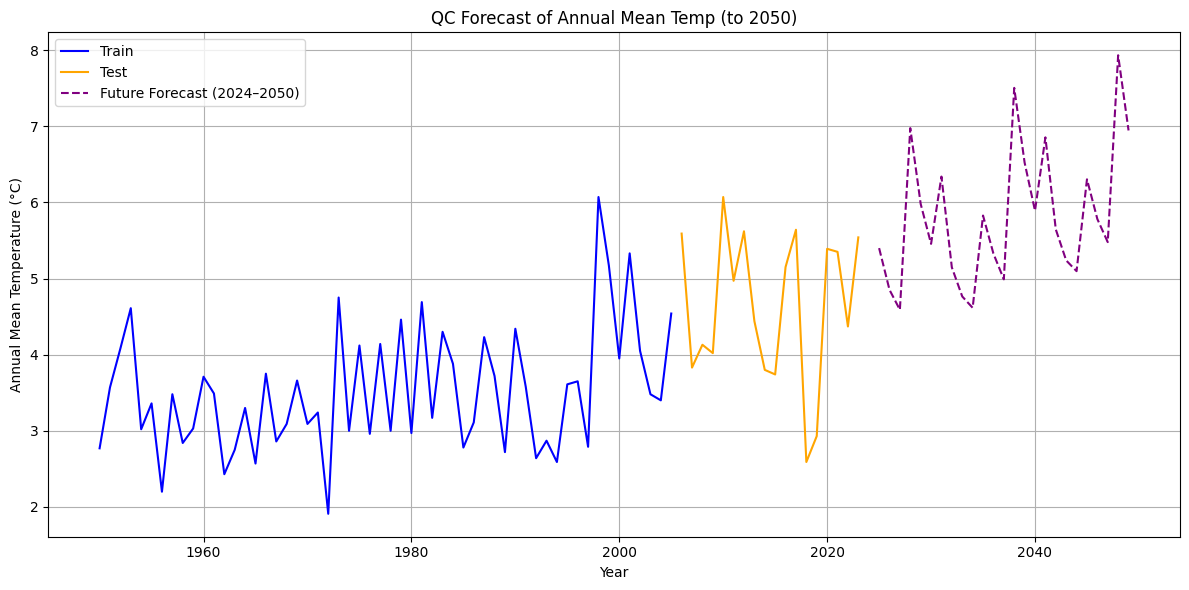

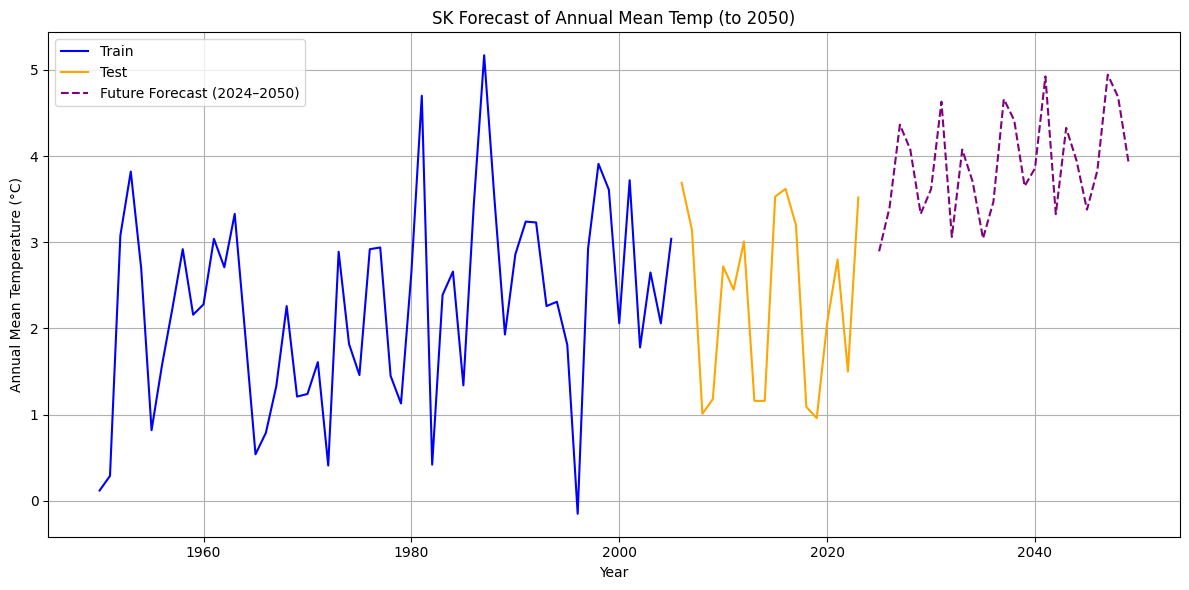

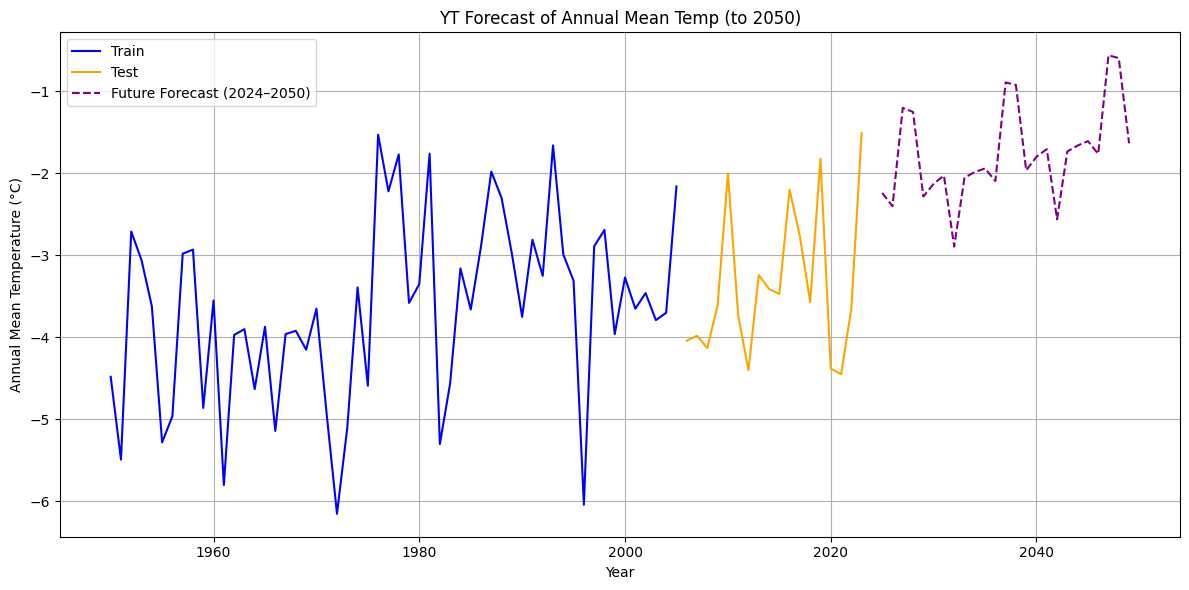

In [ ]:
from pmdarima import auto_arima
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

for province in provinces:

    province_df = df[df["Province"] == province].copy()
    province_df.set_index("Year", inplace=True)


    train = province_df.iloc[:-18]
    test = province_df.iloc[-18:]


    model = SARIMAX(train["Annual_Mean_Temp"],
                    order=(3, 1, 1),
                    seasonal_order=(1, 1, 1, 10),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model = model.fit(disp=False)


    test_pred = model.predict(start=test.index[0], end=test.index[-1], typ="levels")


    last_year = province_df.index[-1]
    future_years = pd.date_range(start=last_year + pd.DateOffset(years=1), periods=25, freq='Y')
    future_forecast = model.predict(start=future_years[0], end=future_years[-1], typ="levels")

    full_series = pd.concat([
        train["Annual_Mean_Temp"],
        test["Annual_Mean_Temp"],
        future_forecast
    ])

    train_mask = full_series.index <= train.index[-1]
    test_mask = (full_series.index > train.index[-1]) & (full_series.index <= test.index[-1])
    future_mask = full_series.index > test.index[-1]

    plt.figure(figsize=(12, 6))
    plt.plot(full_series[train_mask], label="Train", color="blue")
    plt.plot(full_series[test_mask], label="Test", color="orange")
    plt.plot(full_series[future_mask], label="Future Forecast (2024–2050)", color="purple", linestyle="--")

    plt.title(f"{province} Forecast of Annual Mean Temp (to 2050)")
    plt.xlabel("Year")
    plt.ylabel("Annual Mean Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()